<a href="https://colab.research.google.com/github/tniccum21/Dog-Or-Cat/blob/master/DogVsCatClassifierVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# VGGNet for Dogs vs. Cats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, MaxPooling2D,  Conv2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from keras.preprocessing import image
import random
import os
import urllib.request

ROOT = '/content/drive/My Drive'
TRAIN_DATA_PATH = ROOT + '/UDEMY/machine_learning_examples/Dog or Cat/train/train/'
TEST_DATA_PATH = ROOT + '/UDEMY/machine_learning_examples/Dog or Cat/test/test/'
TEMP_STORAGE_PATH = ROOT + '/UDEMY/machine_learning_examples/Dog or Cat/test/'
CHECKPOINT_PATH = ROOT + '/UDEMY/machine_learning_examples/Dog or Cat/train/checkpoint/'
label_map = ['Cat', 'Dog']
IMG_SIZE = 224
CATEGORIES = ['cat','dog']
TRAIN_NEW = True

In [11]:
def show_img(img):
    plt.imshow(img.reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.show()


def getData(imgs_per_cat):
  labels = []
  train_image = []
  cat = 0
  dog = 0
  for item in os.listdir(TRAIN_DATA_PATH):
      if item.split('.')[0] == 'cat':
          if cat >= imgs_per_cat:
            continue
          cat += 1
      elif item.split('.')[0] == 'dog':
          if dog >= imgs_per_cat:
            continue
          dog += 1
      if ((cat+dog) % 100) == 0:
        print(cat, dog, cat+dog)
      img = image.load_img(TRAIN_DATA_PATH + str(item), target_size=(IMG_SIZE, IMG_SIZE))
      img = image.img_to_array(img)
      img = img/255
      train_image.append(img)
      labels.append(item.split('.')[0])
  print(cat, dog)
  l = []
  for item in labels:
      if item == 'cat':
          l.append(0)
      else:
          l.append(1)
  x = np.array(train_image)
  y = np.array(l)
  x,y = shuffle(x, y)
  return x, y

def getTestData(imgs):
  print('Load Test Data')
  labels = []
  train_image = []
  i = 0
  
  for item in sorted(os.listdir(TEST_DATA_PATH)):
      print(str(item))
      img = image.load_img(TEST_DATA_PATH + str(item), target_size=(IMG_SIZE, IMG_SIZE))
      img = image.img_to_array(img)
      img = img/255
      train_image.append(img)
      i += 1
      if i % 100 == 0:
        print(i, item)
      if i == imgs:
        break
  x = np.array(train_image)
  return x

#show accuracy
def calculate_accuracy(p_test, Ytest):
  misclassified_idx = np.where(p_test != Ytest)[0]
  test_acc = np.mean(Ytest == p_test)
  return test_acc, len(misclassified_idx)

def plot_stats(r):
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
        
    plt.plot(r.history['accuracy'], label='acc')
    plt.plot(r.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.show()

def download_image(url):
    print("[INFO] retrieving: {}".format(url))
    train_image = []
    name = str(url.split('/')[-1])
    urllib.request.urlretrieve(url,os.path.join(TEMP_STORAGE_PATH, name))
    img = image.load_img(TEMP_STORAGE_PATH + str(name), target_size=(IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)           
    x = np.array(train_image)
    print('done')
    return x

In [12]:

def get_vgg_model():
  model = VGG16(include_top=False,weights="imagenet",input_shape=(IMG_SIZE,IMG_SIZE,3))
  for layer in model.layers:
    layer.trainable = False
  flat1 = Flatten()(model.layers[-1].output)
  class2 = Dropout(0.4)(flat1)
  class3 = Dense(128, activation='relu')(class2)
  output = Dense(len(CATEGORIES), activation='softmax')(class3)
  model = Model(inputs=model.inputs, outputs=output)
  opt = SGD(lr=0.001, momentum=0.9)
#  model.compile(optimizer=opt, loss='categorical_crossentropy' , metrics=['accuracy'])
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [14]:
def train_dog_v_cat(new=True, imgs=500):

  checkpoint_path = "DogVsCatClassifierVGG.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  model = get_vgg_model() #build_model(IMG_SIZE, IMG_SIZE, 3, K)
  model.summary()
  
  if new:
    validate_split = int(imgs * .20)
    print('read images...')
    Xt, Yt = getData(imgs)
    Xv = Xt[-validate_split:]  # take last 100 as test set
    Yv = Yt[-validate_split:]
    Xt = Xt[:-validate_split] 
    Yt = Yt[:-validate_split] 

    K = len(set(Yt))
    print("Number of classes: ", K)
    print(Xt.shape, Yt.shape)     

# Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
    r = model.fit(Xt, Yt, 
                  epochs=5, 
                  validation_split=0.2, 
                  batch_size=32,
                  callbacks=[cp_callback])
  else:
    model.load_weights(CHECKPOINT_PATH)
  return model

   

In [15]:
model = train_dog_v_cat(True, 2000)
model.save(CHECKPOINT_PATH)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Enter a URL: https://thechive.com/wp-content/uploads/2020/07/Weekend-Afternoon-Randomness-Hotness-Humor-Humanity-DAR-WAR-3-3.jpg
[INFO] retrieving: https://thechive.com/wp-content/uploads/2020/07/Weekend-Afternoon-Randomness-Hotness-Humor-Humanity-DAR-WAR-3-3.jpg
done


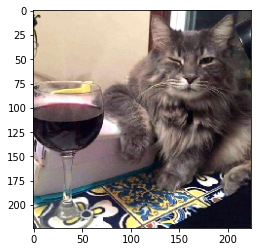

I think this is a  Cat


KeyboardInterrupt: ignored

In [14]:
# internet fun!

while True:
  url = input('Enter a URL (or END): ')
  if url == 'END':
    break
  try:
    Xtest = download_image(url)
  except:
    print("Probable HTTP Error")
    continue
  p_test = model.predict(Xtest)
  p_test2 = np.argmax(p_test, axis=1) # row wise sum
  show_img(Xtest[0])
  print("I think this is a ", label_map[p_test2[0]])